In [1]:
!pip install tensorflow==2.12

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 18:22:20--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.70.232, 52.216.210.232, 54.231.197.96, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.70.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.12MB/s    in 1.8s    

2024-04-07 18:22:22 (7.12 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Analysis of the data of the Jena weather dataset - 420451 rows and 15 Features

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line1 = data.split("\n")
header1 = line1[0].split(",")
line1 = line1[1:]
print(header1)
print(len(line1))

num_variables = len(header1)
print("Number of variables:", num_variables)
num_rows = len(line1)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Following data analysis, specific values are kept in the temperature and raw_data arrays for subsequent processing or analysis. Comma-separated values are transformed to floating-point numbers.

In [4]:
import numpy as np
temp1 = np.zeros((len(line1),))
rawdata1 = np.zeros((len(line1), len(header1) - 1))
for i, line in enumerate(line1):
    values = [float(x) for x in line.split(",")[1:]]
    temp1[i] = values[1]
    rawdata1[i, :] = values[:]

The temperature timeseries plot

Text(0, 0.5, 'Temperature')

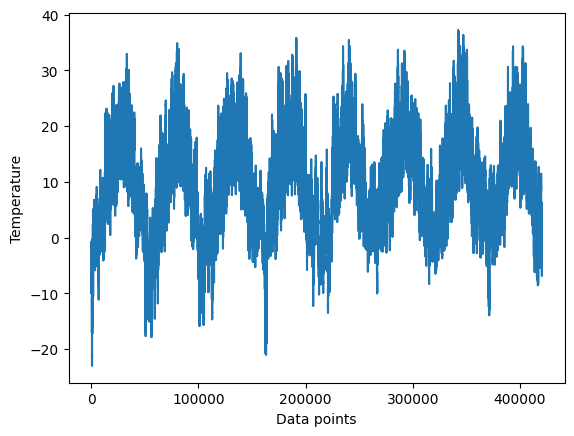

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp1)), temp1)
plt.xlabel('Data points')
plt.ylabel('Temperature')

The temperature time series for the initial 10 days is plotted. 144 data points are gathered in a single day, therefore 1440 data points will be acquired in ten days.

Text(0, 0.5, 'Temperature')

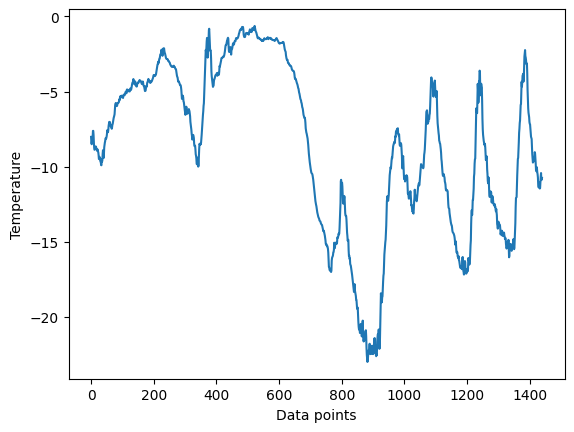

In [6]:
plt.plot(range(1440), temp1[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Figuring out how many samples we'll need for each data split (train = 50%, validation = 25%).

In [7]:
num_of_train = int(0.5 * len(rawdata1))
num_of_validation= int(0.25 * len(rawdata1))
num_of_test= len(rawdata1) - num_of_train - num_of_validation
print("Number of train samples:", num_of_train)
print("Number of validation samples:", num_of_validation)
print("Number of test samples:", num_of_test)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


Preparing the data


Normalizing the data: Since the data is already represented numerically, vectorization is not necessary. Nevertheless, because the data scales differ among them—temperature goes from -20 to +30, and pressure is measured in millibars—it is advisable to standardize all variables.

In [8]:
mean1 = rawdata1[:num_of_train].mean(axis=0)
rawdata1 -= mean1
std = rawdata1[:num_of_train].std(axis=0)
rawdata1 /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence1 = np.arange(10)
dummy_dataset1 = keras.utils.timeseries_dataset_from_array(
    data=int_sequence1[:-3],
    targets=int_sequence1[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset1:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


A significant amount of duplication in the dataset's sample makes the creation of training, validation, and testing datasets essential. To actively allocate RAM for each sample would therefore be inefficient. Instead, the samples will be generated in real time.

In [10]:
sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

training_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_of_train)

validation_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train,
    end_index=num_of_train + num_of_validation)

testing_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train + num_of_validation)

Generating the output of one of this datasets

In [11]:
for samples, targets in training_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline


Calculating the common-sense baseline MAE: The specified function "evaluate_naive_method" provides a foundation for evaluating the efficacy of a simple forecasting method that predicts the value that follows a given value using the final value in the input sequence.

In [12]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean1[1]
        total_absolute_error += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_absolute_error / samples_saw

print(f"Validation MAE: {evaluate_naive_method(validation_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Predicting that the temperature will be the same 24 hours from now is a Common sense basilne approach. The validation mean absolute error (MAE) is 2.44 degrees Celsius whereas the test mean is 2.62 degrees Celsius utilizing this simple baseline. Stated otherwise, there would be an average variance of around 2.5 degrees if the future temperature were constant with the present one.

A basic machine-learning model - Dense Layer


Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
G1 = layers.Flatten()(inputs)
G1 = layers.Dense(16, activation="relu")(G1)
outputs = layers.Dense(1)(G1)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(training_data, epochs=20,
                    validation_data = validation_data, callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 14s 17ms/step - loss: 11.8095 - mae: 2.6610 - val_loss: 9.9858 - val_mae: 2.4926
Epoch 2/20
819/819 [==============================] - 14s 17ms/step - loss: 8.6920 - mae: 2.3139 - val_loss: 9.8567 - val_mae: 2.4792
Epoch 3/20
819/819 [==============================] - 13s 16ms/step - loss: 7.9726 - mae: 2.2186 - val_loss: 9.9308 - val_mae: 2.4924
Epoch 4/20
819/819 [==============================] - 14s 17ms/step - loss: 7.5837 - mae: 2.1635 - val_loss: 10.3730 - val_mae: 2.5455
Epoch 5/20
819/819 [==============================] - 14s 16ms/step - loss: 7.2671 - mae: 2.1183 - val_loss: 11.2820 - val_mae: 2.6619
Epoch 6/20
819/819 [==============================] - 14s 16ms/step - loss: 7.0415 - mae: 2.0837 - val_loss: 11.3721 - val_mae: 2.6625
Epoch 7/20
819/819 [==============================] - 14s 17ms/step - loss: 6.8558 - mae: 2.0563 - val_loss: 10.3903 - val_mae: 2.5403
Epoch 8/20
819/819 [==============================] - 14s

In [19]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 10.9358 - mae: 2.5953
Test MAE: 2.60


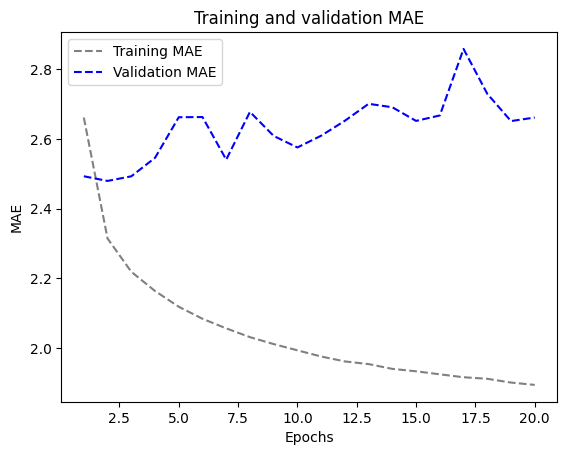

In [20]:
import matplotlib.pyplot as plt
loss1 = history.history["mae"]
validation_loss = history.history["val_mae"]

epochs = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs, loss1, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1D = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 18ms/step - loss: 22.1444 - mae: 3.6695 - val_loss: 16.9905 - val_mae: 3.2431
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 15.1880 - mae: 3.0848 - val_loss: 15.7083 - val_mae: 3.1601
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.0468 - mae: 2.9651 - val_loss: 15.5625 - val_mae: 3.1154
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 13.2346 - mae: 2.8766 - val_loss: 15.5562 - val_mae: 3.0765
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 12.5891 - mae: 2.8058 - val_loss: 16.8939 - val_mae: 3.1864
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 12.0712 - mae: 2.7465 - val_loss: 14.5772 - val_mae: 3.0132
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.6751 - mae: 2.7013 - val_loss: 15.6174 - val_mae: 3.1037
Epoch 8/10
819/819 [============================

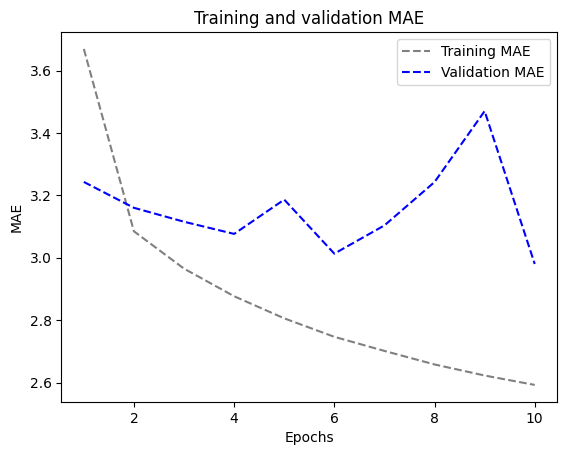

In [ ]:
import matplotlib.pyplot as plt
loss1D = history1D.history["mae"]
validation_loss1D = history1D.history["val_mae"]

epochs = range(1, len(loss1D) + 1)
plt.figure()
plt.plot(epochs, loss1D, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss1D, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Dense models or common sense seem to outperform convolutional data. That might be because of

Weather data does not conform to the translation invariance assumption.
The order in which the information is provided is crucial. Recent past data is notably more beneficial than data acquired many days in advance when it comes to predicting the temperature for the next day. Sadly, a 1D convolutional neural network is not able to adequately represent this significant temporal order.

A Simple RNN

1.An RNN layer that can process sequences of any length

In [ ]:
the_features = 14
input_RNN = keras.Input(shape=(None, the_features))
output_RNN = layers.SimpleRNN(16)(input_RNN)

models_RNN = keras.Model(input_RNN, output_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
models_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_RNN = models_RNN.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {models_RNN.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 23s 27ms/step - loss: 138.5475 - mae: 9.6872 - val_loss: 144.0951 - val_mae: 9.9095
Epoch 2/5
819/819 [==============================] - 22s 27ms/step - loss: 136.4265 - mae: 9.5640 - val_loss: 143.7113 - val_mae: 9.8709
Epoch 3/5
819/819 [==============================] - 22s 27ms/step - loss: 136.2574 - mae: 9.5464 - val_loss: 143.6329 - val_mae: 9.8597
Epoch 4/5
819/819 [==============================] - 22s 27ms/step - loss: 136.2260 - mae: 9.5448 - val_loss: 143.6229 - val_mae: 9.8617
Epoch 5/5
405/405 [==============================] - 5s 11ms/step - loss: 151.2971 - mae: 9.9207
Test MAE: 9.92


2.Simple RNN - Stacking RNN layers

In [ ]:
the_features2 = 14
steps = 120
inpu2 = keras.Input(shape=(steps, the_features2))
a = layers.SimpleRNN(16, return_sequences=True)(inpu2)
a = layers.SimpleRNN(16, return_sequences=True)(a)
outpu2 = layers.SimpleRNN(16)(a)
models2 = keras.Model(inpu2, outpu2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
models2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = models2.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {models2.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 64s 76ms/step - loss: 137.0129 - mae: 9.5715 - val_loss: 143.4090 - val_mae: 9.8341
Epoch 2/5
819/819 [==============================] - 62s 75ms/step - loss: 135.9462 - mae: 9.5099 - val_loss: 143.3981 - val_mae: 9.8331
Epoch 3/5
819/819 [==============================] - 62s 75ms/step - loss: 135.9085 - mae: 9.5044 - val_loss: 143.3791 - val_mae: 9.8300
Epoch 4/5
819/819 [==============================] - 62s 75ms/step - loss: 135.8848 - mae: 9.5003 - val_loss: 143.3992 - val_mae: 9.8331
Epoch 5/5
405/405 [==============================] - 10s 23ms/step - loss: 151.1016 - mae: 9.9025
Test MAE: 9.90


A Simple GRU (Gated Recurrent Unit)

In [ ]:
inputs_GRU = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
b = layers.GRU(16)(inputs_GRU)
outputs_GRU = layers.Dense(1)(b)
models_GRU = keras.Model(inputs_GRU, outputs_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
models_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_GRU = models_GRU.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {models_GRU.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 52s 61ms/step - loss: 39.8384 - mae: 4.5785 - val_loss: 13.2089 - val_mae: 2.7335
Epoch 2/5
819/819 [==============================] - 50s 61ms/step - loss: 10.7754 - mae: 2.5535 - val_loss: 11.1656 - val_mae: 2.5317
Epoch 3/5
819/819 [==============================] - 50s 61ms/step - loss: 9.9705 - mae: 2.4651 - val_loss: 10.7305 - val_mae: 2.4902
Epoch 4/5
819/819 [==============================] - 50s 61ms/step - loss: 9.6804 - mae: 2.4263 - val_loss: 9.6660 - val_mae: 2.4043
Epoch 5/5
405/405 [==============================] - 9s 20ms/step - loss: 10.4814 - mae: 2.5354
Test MAE: 2.54


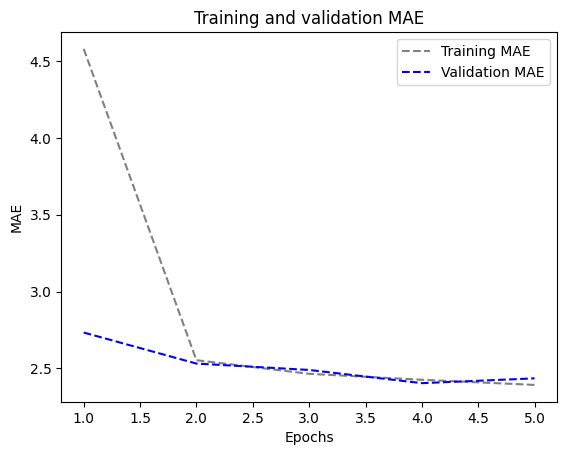

In [ ]:
import matplotlib.pyplot as plt
loss_GRU = history_GRU.history["mae"]
validation_loss_GRU = history_GRU.history["val_mae"]

epochs = range(1, len(loss_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [ ]:
inputs_LSTMS = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
c = layers.LSTM(16)(inputs_LSTMS)
output_LSTMS = layers.Dense(1)(c)
model_LSTMS = keras.Model(inputs_LSTMS, output_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMS = model_LSTMS.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 52s 61ms/step - loss: 41.7439 - mae: 4.7148 - val_loss: 13.0359 - val_mae: 2.7549
Epoch 2/5
819/819 [==============================] - 50s 61ms/step - loss: 11.2411 - mae: 2.6091 - val_loss: 9.8813 - val_mae: 2.4607
Epoch 3/5
819/819 [==============================] - 50s 61ms/step - loss: 10.0663 - mae: 2.4743 - val_loss: 10.0417 - val_mae: 2.4628
Epoch 4/5
819/819 [==============================] - 50s 61ms/step - loss: 9.7061 - mae: 2.4258 - val_loss: 9.6404 - val_mae: 2.4134
Epoch 5/5
819/819 [==============================] - 50s 61ms/step - loss: 9.3777 - mae: 2.3842 - val_loss: 9.4085 - val_mae: 2.3927


In [ ]:
model_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_LSTMS.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 10s 23ms/step - loss: 10.7087 - mae: 2.5685
Test MAE: 2.57


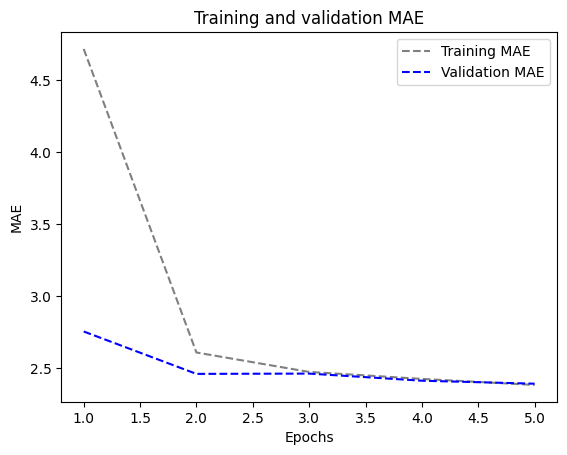

In [ ]:
import matplotlib.pyplot as plt
loss_LSTMS = history_LSTMS.history["mae"]
validation_loss_LSTMS = history_LSTMS.history["val_mae"]

epochs = range(1, len(loss_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [ ]:
input_LSTMR = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
d = layers.LSTM(16, recurrent_dropout=0.25)(input_LSTMR )
d = layers.Dropout(0.5)(d)
output_LSTMR = layers.Dense(1)(d)
model_LSTMR = keras.Model(input_LSTMR , output_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMR = model_LSTMR.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 68s 81ms/step - loss: 49.9203 - mae: 5.2715 - val_loss: 13.8906 - val_mae: 2.8132
Epoch 2/5
819/819 [==============================] - 67s 81ms/step - loss: 20.1225 - mae: 3.4468 - val_loss: 10.1687 - val_mae: 2.4799
Epoch 3/5
819/819 [==============================] - 66s 81ms/step - loss: 18.1616 - mae: 3.2797 - val_loss: 9.5384 - val_mae: 2.4154
Epoch 4/5
819/819 [==============================] - 66s 81ms/step - loss: 17.2436 - mae: 3.1952 - val_loss: 9.2571 - val_mae: 2.3762
Epoch 5/5
819/819 [==============================] - 66s 81ms/step - loss: 16.5456 - mae: 3.1335 - val_loss: 9.2204 - val_mae: 2.3636


In [ ]:
model_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_LSTMR.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 8s 19ms/step - loss: 10.5803 - mae: 2.5572
Test MAE: 2.56


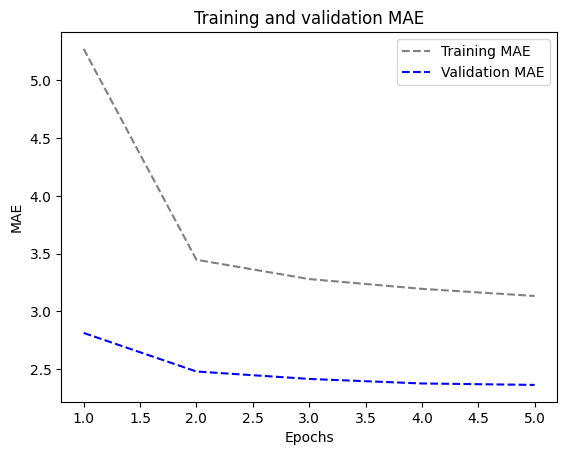

In [ ]:
import matplotlib.pyplot as plt
loss_LSTMR = history_LSTMR .history["mae"]
validation_loss_LSTMR = history_LSTMR .history["val_mae"]

epochs = range(1, len(loss_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

3.LSTM - Stacked setup with 16 units

In [ ]:
input_16 = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
e = layers.LSTM(16, return_sequences=True)(input_16)
e = layers.LSTM(16)(e)
output_16 = layers.Dense(1)(e)
model_16 = keras.Model(input_16, output_16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model_16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_16 = model_16.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/5
819/819 [==============================] - 100s 118ms/step - loss: 39.5802 - mae: 4.5547 - val_loss: 12.7088 - val_mae: 2.7027
Epoch 2/5
819/819 [==============================] - 96s 117ms/step - loss: 10.0889 - mae: 2.4595 - val_loss: 10.2406 - val_mae: 2.4911
Epoch 3/5
819/819 [==============================] - 96s 118ms/step - loss: 8.6991 - mae: 2.2965 - val_loss: 10.5976 - val_mae: 2.5399
Epoch 4/5
819/819 [==============================] - 96s 117ms/step - loss: 8.0312 - mae: 2.2088 - val_loss: 10.8730 - val_mae: 2.5865
Epoch 5/5
819/819 [==============================] - 96s 117ms/step - loss: 7.5006 - mae: 2.1335 - val_loss: 11.0305 - val_mae: 2.5805


In [ ]:
model_16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model_16.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 18s 42ms/step - loss: 11.3910 - mae: 2.6347
Test MAE: 2.63


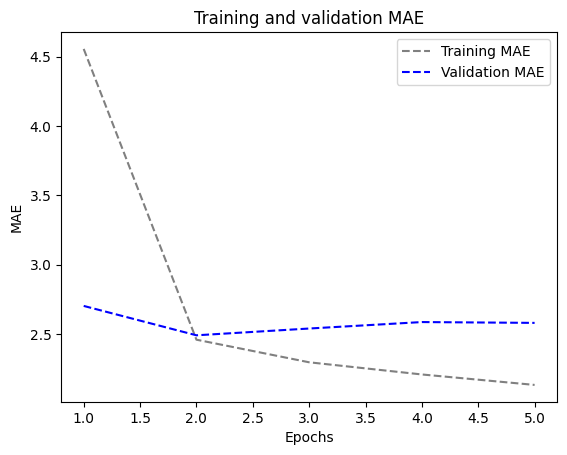

In [ ]:
import matplotlib.pyplot as plt
loss_16 = history_16.history["mae"]
validation_loss_16 = history_16.history["val_mae"]

epochs = range(1, len(loss_16) + 1)
plt.figure()
plt.plot(epochs, loss_16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 32 units

In [ ]:
input_32 = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
f = layers.LSTM(32, return_sequences=True)(input_32)
f = layers.LSTM(32)(f)
output_32 = layers.Dense(1)(f)
model_32 = keras.Model(input_32, output_32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model_32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_32 = model_32.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 139s 166ms/step - loss: 19.8560 - mae: 3.2408 - val_loss: 10.6135 - val_mae: 2.5511
Epoch 2/10
819/819 [==============================] - 136s 166ms/step - loss: 8.0834 - mae: 2.2184 - val_loss: 10.6714 - val_mae: 2.5256
Epoch 3/10
819/819 [==============================] - 135s 165ms/step - loss: 6.3782 - mae: 1.9686 - val_loss: 11.3444 - val_mae: 2.6298
Epoch 4/10
819/819 [==============================] - 136s 166ms/step - loss: 5.2819 - mae: 1.7877 - val_loss: 12.2656 - val_mae: 2.7325
Epoch 5/10
819/819 [==============================] - 135s 165ms/step - loss: 4.4177 - mae: 1.6312 - val_loss: 13.4216 - val_mae: 2.8293
Epoch 6/10
819/819 [==============================] - 136s 166ms/step - loss: 3.7819 - mae: 1.5086 - val_loss: 14.0508 - val_mae: 2.9264
Epoch 7/10
819/819 [==============================] - 136s 165ms/step - loss: 3.2831 - mae: 1.4051 - val_loss: 14.4979 - val_mae: 2.9612
Epoch 8/10
819/819 [====================

In [ ]:
model_32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model_32.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 27s 64ms/step - loss: 11.7041 - mae: 2.6838
Test MAE: 2.68


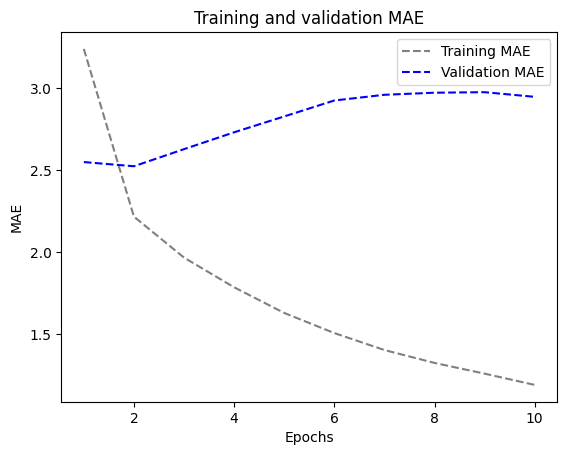

In [ ]:
import matplotlib.pyplot as plt
loss_32 = history_32.history["mae"]
validation_loss_32 = history_32.history["val_mae"]

epochs = range(1, len(loss_32) + 1)
plt.figure()
plt.plot(epochs, loss_32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - Stacked setup with 8 units

In [ ]:
input_8u = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
h = layers.LSTM(8, return_sequences=True)(input_8u)
h = layers.LSTM(8)(h)
output_8u = layers.Dense(1)(h)
model_8u = keras.Model(input_8u, output_8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model_8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8u = model_8u.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 85s 100ms/step - loss: 70.6401 - mae: 6.4259 - val_loss: 35.1753 - val_mae: 4.3867
Epoch 2/10
819/819 [==============================] - 81s 99ms/step - loss: 21.0936 - mae: 3.3918 - val_loss: 12.8402 - val_mae: 2.6921
Epoch 3/10
819/819 [==============================] - 82s 99ms/step - loss: 11.1445 - mae: 2.5822 - val_loss: 10.0331 - val_mae: 2.4593
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 9.9313 - mae: 2.4547 - val_loss: 9.9301 - val_mae: 2.4462
Epoch 5/10
819/819 [==============================] - 81s 99ms/step - loss: 9.6237 - mae: 2.4147 - val_loss: 10.0378 - val_mae: 2.4652
Epoch 6/10
819/819 [==============================] - 82s 99ms/step - loss: 9.4078 - mae: 2.3863 - val_loss: 9.8334 - val_mae: 2.4448
Epoch 7/10
819/819 [==============================] - 81s 99ms/step - loss: 9.1820 - mae: 2.3537 - val_loss: 9.8662 - val_mae: 2.4506
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model_8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model_8u.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 10.7092 - mae: 2.5793
Test MAE: 2.58


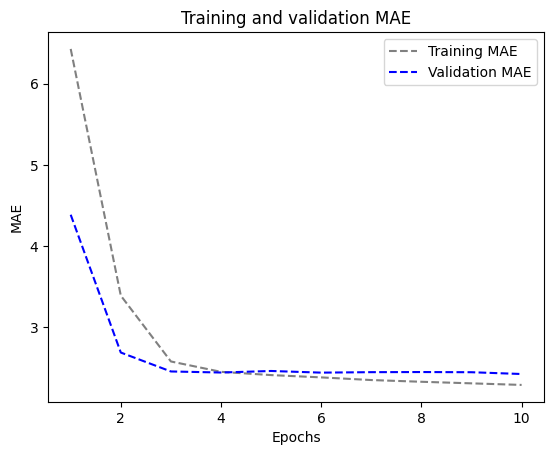

In [ ]:
import matplotlib.pyplot as plt
loss_8u = history_8u.history["mae"]
validation_loss_8u = history_8u.history["val_mae"]

epochs = range(1, len(loss_8u) + 1)
plt.figure()
plt.plot(epochs, loss_8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

6.LSTM - dropout-regularized, stacked model

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
i = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
i = layers.LSTM(8, recurrent_dropout=0.5)(i)
i = layers.Dropout(0.5)(i)
outputs = layers.Dense(1)(i)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 123s 146ms/step - loss: 74.0595 - mae: 6.6088 - val_loss: 34.7545 - val_mae: 4.3899
Epoch 2/10
819/819 [==============================] - 119s 146ms/step - loss: 31.8577 - mae: 4.2218 - val_loss: 13.6903 - val_mae: 2.7574
Epoch 3/10
819/819 [==============================] - 119s 145ms/step - loss: 24.4364 - mae: 3.7448 - val_loss: 11.2331 - val_mae: 2.5636
Epoch 4/10
819/819 [==============================] - 119s 146ms/step - loss: 22.4799 - mae: 3.5999 - val_loss: 10.0102 - val_mae: 2.4320
Epoch 5/10
819/819 [==============================] - 119s 145ms/step - loss: 21.2827 - mae: 3.5031 - val_loss: 9.5838 - val_mae: 2.3791
Epoch 6/10
819/819 [==============================] - 119s 145ms/step - loss: 20.2977 - mae: 3.4310 - val_loss: 9.5677 - val_mae: 2.3815
Epoch 7/10
819/819 [==============================] - 119s 145ms/step - loss: 19.3459 - mae: 3.3558 - val_loss: 9.5638 - val_mae: 2.3905
Epoch 8/10
819/819 [=================

In [ ]:
model_r = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model_r.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 10.6185 - mae: 2.5360
Test MAE: 2.54


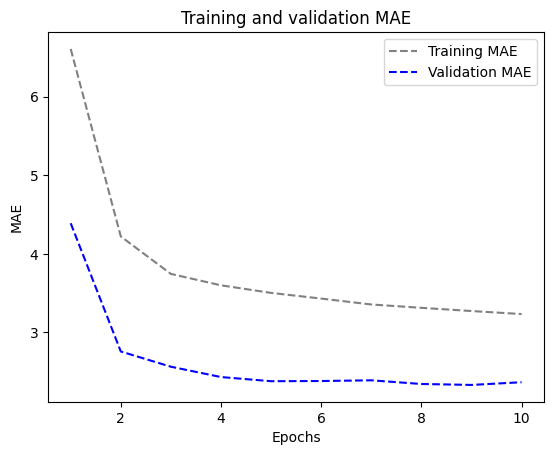

In [ ]:
import matplotlib.pyplot as plt
loss_r = history.history["mae"]
validation_loss_r = history.history["val_mae"]

epochs = range(1, len(loss_r) + 1)
plt.figure()
plt.plot(epochs, loss_r, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_r, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history.bi = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 61s 71ms/step - loss: 26.7302 - mae: 3.6974 - val_loss: 10.6651 - val_mae: 2.5137
Epoch 2/5
819/819 [==============================] - 57s 69ms/step - loss: 9.4427 - mae: 2.3928 - val_loss: 9.5172 - val_mae: 2.3821
Epoch 3/5
819/819 [==============================] - 57s 70ms/step - loss: 8.4923 - mae: 2.2606 - val_loss: 10.0798 - val_mae: 2.4544
Epoch 4/5
819/819 [==============================] - 58s 70ms/step - loss: 8.0057 - mae: 2.1919 - val_loss: 10.0984 - val_mae: 2.4702
Epoch 5/5
819/819 [==============================] - 57s 70ms/step - loss: 7.6831 - mae: 2.1480 - val_loss: 10.0597 - val_mae: 2.4574


In [ ]:
model_bi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model_bi.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 12s 27ms/step - loss: 10.8290 - mae: 2.5671
Test MAE: 2.57


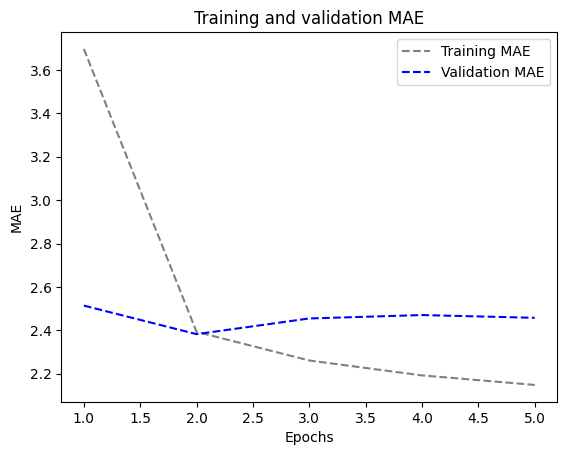

In [ ]:
import matplotlib.pyplot as plt
loss_bi = history.bi.history["mae"]
validation_loss_bi = history.bi.history["val_mae"]

epochs = range(1, len(loss_bi) + 1)
plt.figure()
plt.plot(epochs, loss_bi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_bi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [ ]:
input_final = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
l = layers.Conv1D(64, 3, activation='relu')(input_final)
l = layers.MaxPooling1D(3)(l)
l = layers.Conv1D(128, 3, activation='relu')(l)
l = layers.GlobalMaxPooling1D()(l)
l = layers.Reshape((-1, 128))(l)  # Reshape the data to be 3D
l = layers.LSTM(16)(l)
output_final = layers.Dense(1)(l)
model_final = keras.Model(input_final, output_final)

model_final.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_final = model_final.fit(training_data, epochs=5, validation_data=validation_data, callbacks=callbacks)



Epoch 1/5
819/819 [==============================] - 20s 22ms/step - loss: 44.8877 - mae: 5.0064 - val_loss: 24.4481 - val_mae: 3.8367
Epoch 2/5
819/819 [==============================] - 17s 21ms/step - loss: 17.1788 - mae: 3.2103 - val_loss: 20.8368 - val_mae: 3.6123
Epoch 3/5
819/819 [==============================] - 17s 21ms/step - loss: 14.0989 - mae: 2.9200 - val_loss: 22.7527 - val_mae: 3.7484
Epoch 4/5
819/819 [==============================] - 17s 21ms/step - loss: 12.5468 - mae: 2.7461 - val_loss: 26.6769 - val_mae: 4.1778
Epoch 5/5
819/819 [==============================] - 17s 21ms/step - loss: 11.4257 - mae: 2.6111 - val_loss: 23.7673 - val_mae: 3.8498


In [ ]:
model_final = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_final.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 5s 11ms/step - loss: 22.8396 - mae: 3.7835
Test MAE: 3.78


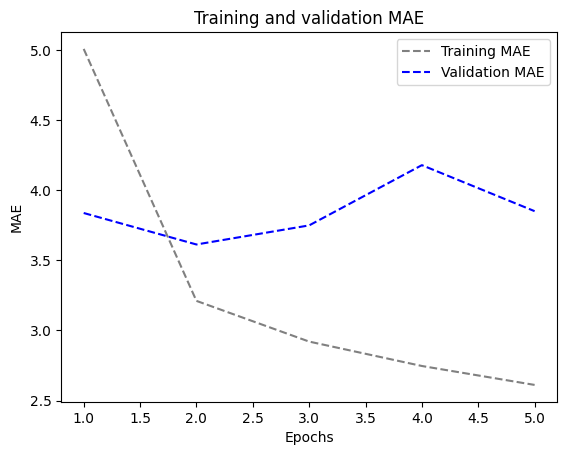

In [ ]:
import matplotlib.pyplot as plt
loss_final = history_final.history["mae"]
validation_loss_final = history_final.history["val_mae"]

epochs = range(1, len(loss_final) + 1)
plt.figure()
plt.plot(epochs, loss_final, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_final, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

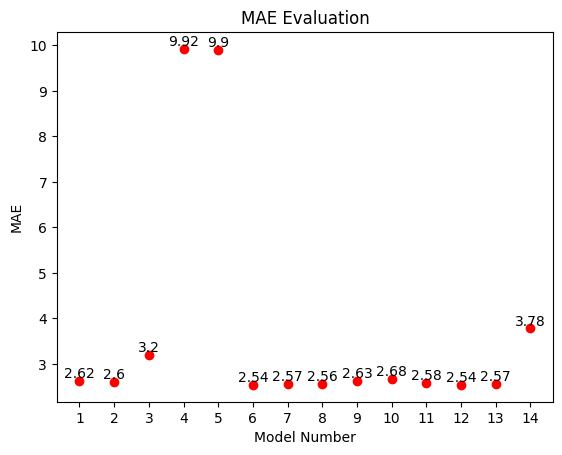

In [18]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.2,9.92,9.9,2.54,2.57,2.56,2.63,2.68,2.58,2.54,2.57,3.78)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

